In [3]:
import xgboost as xgb
import pandas as pd
import numpy as np
from joblib import load, dump
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
''' 
0 - normal
1 - dos
2 - portscan
3 - bruteforce
'''
df = pd.read_csv("custom_data/normal/extracted_normal.csv")
print(df.shape)

df = pd.concat([df, pd.read_csv("custom_data/normal/extracted_normal2.csv")], ignore_index=True)
print(df.shape)

df = pd.concat([df, pd.read_csv("custom_data/normal/normal_vm.csv")], ignore_index=True)
print(df.shape)

df = pd.concat([df, pd.read_csv("custom_data/normal/normal_vm_soy.csv")], ignore_index=True)
print(df.shape)

df = pd.concat([df, pd.read_csv("custom_data/normal/extracted_normal4.csv")], ignore_index=True)
print(df.shape)

df['Label'] = 0


(111, 41)
(205, 41)
(206, 41)
(208, 41)
(222, 41)


In [5]:
df_at = pd.read_csv("custom_data/golden_eye/golden_eye_v1_1.csv")
print(df_at.shape)

df_at = pd.concat([df_at, pd.read_csv("custom_data/golden_eye/golden_eye_v1_2.csv")], ignore_index=True)
print(df_at.shape)

df_at = pd.concat([df_at, pd.read_csv("custom_data/golden_eye/golden_eye_v2_1.csv")], ignore_index=True)
print(df_at.shape)

df_at['Label'] = 1

(2894, 41)
(4624, 41)
(7073, 41)


In [11]:
df_portscan = pd.read_csv("custom_data/all_attacks/portscan.csv")
print(df_portscan.shape)

df_portscan['Label'] = 2

(424, 41)


In [12]:
df_slowloris = pd.read_csv("custom_data/all_attacks/slowloris.csv")
print(df_slowloris.shape)

df_slowloris['Label'] = 3

(150, 41)


In [13]:
df_hulk = pd.read_csv("custom_data/all_attacks/hulk_dos.csv")
print(df_hulk.shape)

df_hulk['Label'] = 4

(4555, 41)


In [15]:
#df = pd.concat([df, df_at], ignore_index=True)
#print(df.shape)

df = pd.concat([df, df_at,df_portscan,df_slowloris,df_hulk], ignore_index=True)
print(df.shape)

(12424, 42)


In [16]:
#print(df['Label'].value_counts())

print(df['Label'].value_counts())

Label
1    7073
4    4555
2     424
0     222
3     150
Name: count, dtype: int64


In [17]:
imp_feats = ['Average Packet Size', 'Bwd Packet Length Std', 'Bwd Header Length', 'Destination Port', 'Bwd Packet Length Max', 'Max Packet Length', 'Avg Bwd Segment Size', 'Packet Length Std', 'Bwd Packet Length Mean', 'Packet Length Mean', 'PSH Flag Count', 'Packet Length Variance', 'Bwd Packet Length Min', 'Fwd Packet Length Min', 'Fwd Packet Length Max', 'Init_Win_bytes_forward', 'Subflow Bwd Bytes', 'Total Length of Bwd Packets', 'Flow IAT Mean', 'Total Length of Fwd Packets', 'Min Packet Length', 'Fwd Packet Length Mean', 'Fwd IAT Max', 'Active Min', 'URG Flag Count', 'Fwd IAT Std', 'Subflow Fwd Packets', 'Flow IAT Max', 'Flow Bytes/s', 'Avg Fwd Segment Size']


In [18]:
# Define the sample size range for each class
min_samples = 200
max_samples = 220

# Function to randomly sample within the range [min_samples, max_samples]
def random_sample_class(df, label, min_samples, max_samples):
    n_samples = np.random.randint(min_samples, max_samples + 1)
    return resample(df[df['Label'] == label], n_samples=n_samples, random_state=42)

# Define the labels to be resampled
class_labels = [1, 4, 2]

# Apply the random_sample_class function to each class
resampled_dfs = [random_sample_class(df, label, min_samples, max_samples) for label in class_labels]
df_resampled = pd.concat(resampled_dfs + [df[df['Label'] == label] for label in df['Label'].unique() if label not in class_labels])
df = df_resampled

print(df['Label'].value_counts())


Label
4    4555
2     424
0     222
1     219
3     150
Name: count, dtype: int64


In [19]:
x = df[imp_feats]
y = df['Label']

print(x.shape)



(5570, 30)


In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state = 0, stratify = y)
print(x_train.shape, y_train.shape)

(4456, 30) (4456,)


Accuracy of new DT:  0.9874326750448833
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        44
           1       0.97      0.75      0.85        44
           2       1.00      1.00      1.00        85
           3       1.00      1.00      1.00        30
           4       0.99      1.00      0.99       911

    accuracy                           0.99      1114
   macro avg       0.99      0.94      0.96      1114
weighted avg       0.99      0.99      0.99      1114



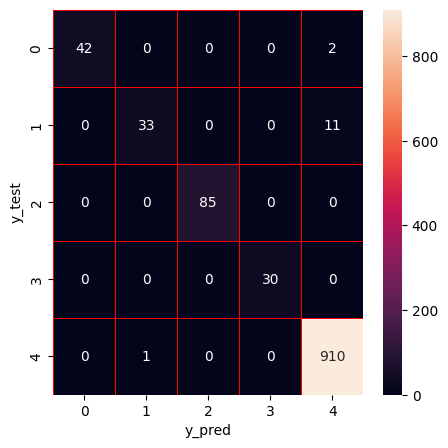

In [23]:
dt = DecisionTreeClassifier(criterion='gini', splitter= 'best', max_depth=5)
dt.fit(x_train,y_train)

y_pred = dt.predict(x_test)

print('Accuracy of new DT: ', dt.score(x_test, y_test))
print(classification_report(y_test,y_pred))
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.show()


In [11]:
# Validation on real-time data

df_val_nrml = pd.read_csv("custom_data/normal/extracted_normal4.csv")
df_val_nrml['Label'] = 0

print(df_val_nrml.shape)

(14, 42)


In [12]:
# x_val_nrml = df_val_nrml[imp_feats]
# y_val_nrml = df_val_nrml['Label']

# y_val_nrml_pred = dt.predict(x_val_nrml)

# print('Accuracy of new DT on realtime data: ', dt.score(x_val_nrml, y_val_nrml))
# print(classification_report(y_val_nrml, y_val_nrml_pred))
# cm=confusion_matrix(y_val_nrml,y_val_nrml_pred)
# f,ax=plt.subplots(figsize=(5,5))
# sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
# plt.xlabel("y_pred")
# plt.ylabel("y_test")
# plt.show()




In [13]:
# Validation on real time
df_val_gld = pd.read_csv("custom_data/golden_eye/golden_eye_v2_2.csv")
df_val_gld['Label'] = 1

# x_val_gld = df_val_gld[imp_feats]
# y_val_gld = df_val_gld['Label']

# y_pred = dt.predict(x_val_gld)

# print('Accuracy of new DT: ', dt.score(x_val_gld, y_val_gld))


Accuracy of new DT on realtime data:  0.9935691318327974
              precision    recall  f1-score   support

           0       0.46      0.93      0.62        14
           1       1.00      0.99      1.00      2474

    accuracy                           0.99      2488
   macro avg       0.73      0.96      0.81      2488
weighted avg       1.00      0.99      0.99      2488



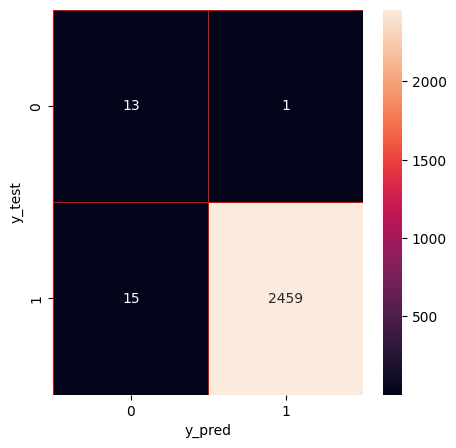

In [14]:
df_val = pd.concat([df_val_nrml, df_val_gld]) 

x_val = df_val[imp_feats]
y_val = df_val['Label']

pred = dt.predict(x_val)

print('Accuracy of new DT on realtime data: ', dt.score(x_val, y_val))
print(classification_report(y_val, pred))
cm=confusion_matrix(y_val, pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.show()




In [24]:
dump(dt, "models/dt2.joblib")

['models/dt2.joblib']

In [ ]:
''' 
1st iteration problems:
    vm normal misclassified as attack

2nd iteration 

'''